In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import HuberRegressor



plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)

In [2]:
data = pd.read_csv('processed_data.csv')
data = data[data['yyyymm'] % 100 == 12] # restrict sample size

In [3]:
# recursive evaluation
predictors = [v for v in list(data.columns) if v not in ['permno', 'yyyymm', 'RET']]
test_score = [0] * 30
models = []

for i in range(30):
    data_train = data[(data.yyyymm >= 196001 + i * 100) & (data.yyyymm < 197801 + i * 100)]
    data_validation = data[(data.yyyymm >= 197801 + i * 100) & (data.yyyymm < 199001 + i * 100)]
    data_test = data[(data.yyyymm >= 199001 + i*100) & (data.yyyymm < 199101 + i * 100)]
    print(f'batch {i}')
    print(f'train: {1960 + i}-{1978 + i}  size: {len(data_train)}')
    print(f'validate: {1978 + i}-{1990 + i}  size: {len(data_validation)}')
    print(f'test: {1990 + i}-{1991 + i}  size: {len(data_test)}')

    #Normalize
    X_train = data_train[predictors]
    X_validation = data_validation[predictors]
    X_all = pd.concat([X_train, X_validation], axis=0)
    
    X_test = data_test[predictors]

    y_train = data_train["RET"]
    y_validation = data_validation["RET"]
    y_all = pd.concat([y_train, y_validation], axis=0)
    
    y_test = data_test["RET"]
    
   # Fit the OLS_H model using the training data
    
    #The authors choose $\xi$ as 99.9% percentile 
    
    abs_values = np.abs(X_all)
    threshold = np.percentile(abs_values, 99.9)
    values_greater_than_threshold = abs_values[abs_values > threshold]
    size = len(values_greater_than_threshold)
    
    epsilon = max(size, 1)
    
    olsh = HuberRegressor(epsilon=epsilon).fit(X_all,y_all)

    # Predict the target variable using the test data
    y_test_pred = olsh.predict(X_test)

    # Evaluate the model's performance
    test_score[i] = r2_score(y_test,y_test_pred)
   
    models.append(olsh.fit(X_all, y_all))




batch 0
train: 1960-1978  size: 52060
validate: 1978-1990  size: 71704
test: 1990-1991  size: 6704
batch 1
train: 1961-1979  size: 55788
validate: 1979-1991  size: 73566
test: 1991-1992  size: 6788
batch 2
train: 1962-1980  size: 59446
validate: 1980-1992  size: 75555
test: 1992-1993  size: 6905
batch 3
train: 1963-1981  size: 62356
validate: 1981-1993  size: 77503
test: 1993-1994  size: 7638
batch 4
train: 1964-1982  size: 65654
validate: 1982-1994  size: 79786
test: 1994-1995  size: 8182
batch 5
train: 1965-1983  size: 69030
validate: 1983-1995  size: 82472
test: 1995-1996  size: 8396
batch 6
train: 1966-1984  size: 72971
validate: 1984-1996  size: 84783
test: 1996-1997  size: 9016
batch 7
train: 1967-1985  size: 77073
validate: 1985-1997  size: 87506
test: 1997-1998  size: 9140
batch 8
train: 1968-1986  size: 81176
validate: 1986-1998  size: 90346
test: 1998-1999  size: 8744
batch 9
train: 1969-1987  size: 85625
validate: 1987-1999  size: 92452
test: 1999-2000  size: 8379
batch 10
t

mean performance: -0.8550218080697145


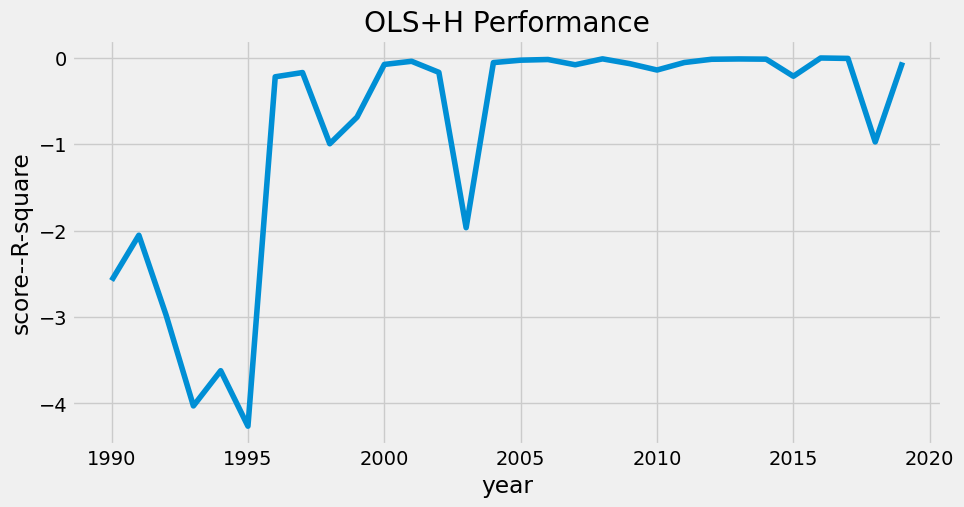

In [4]:
# Performence of OLSH models
plt.figure(figsize=(10,5))
plt.title("OLS+H Performance")
year=np.arange(1990, 2020)
plt.plot(year, test_score)
plt.xlabel("year")
plt.ylabel("score--R-square")
print("mean performance: {}".format(np.mean(test_score)))

Text(0, 0.5, 'complexity')

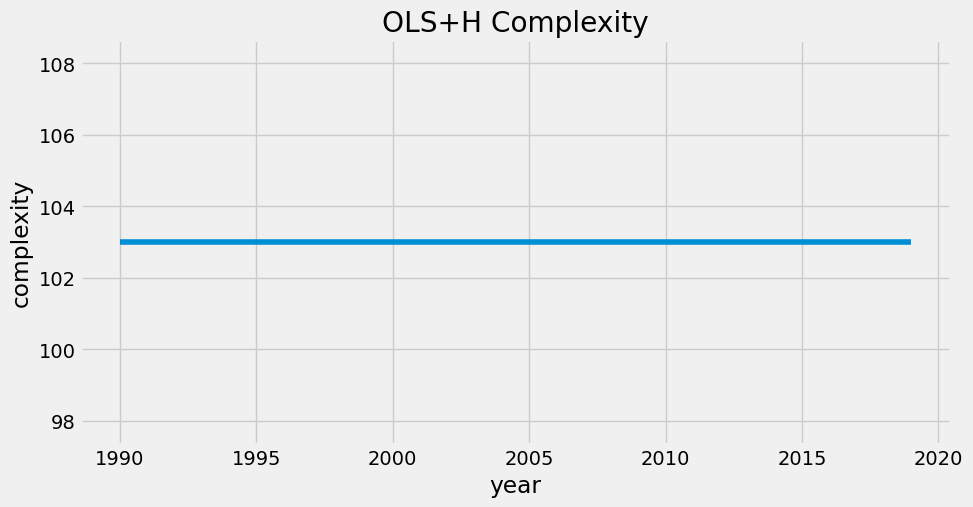

In [5]:
# Model complexities OLSH
complexities = []
for m in models:
    complexities.append(len(m.coef_.nonzero()[0]))

plt.figure(figsize=(10,5))
plt.title("OLS+H Complexity")
year=np.arange(1990, 2020)
plt.plot(year, complexities)
plt.xlabel("year")
plt.ylabel("complexity")

In [6]:
#Variable importance
var_importance = np.zeros([30, len(predictors)])
for i in range(30):
    model = models[i]
    d = data[(data.yyyymm >= 199001 + i*100) & (data.yyyymm < 199101 + i * 100)]
    X = d[predictors]
    y = d['RET']
    for j in range(len(predictors)):
        X_mod = X.copy()
        X_mod.loc[:, predictors[j]] = 0
        score = r2_score(y, model.predict(X_mod))
        var_importance[i][j] = test_score[i] - score
        del X_mod

<Axes: ylabel='predictor'>

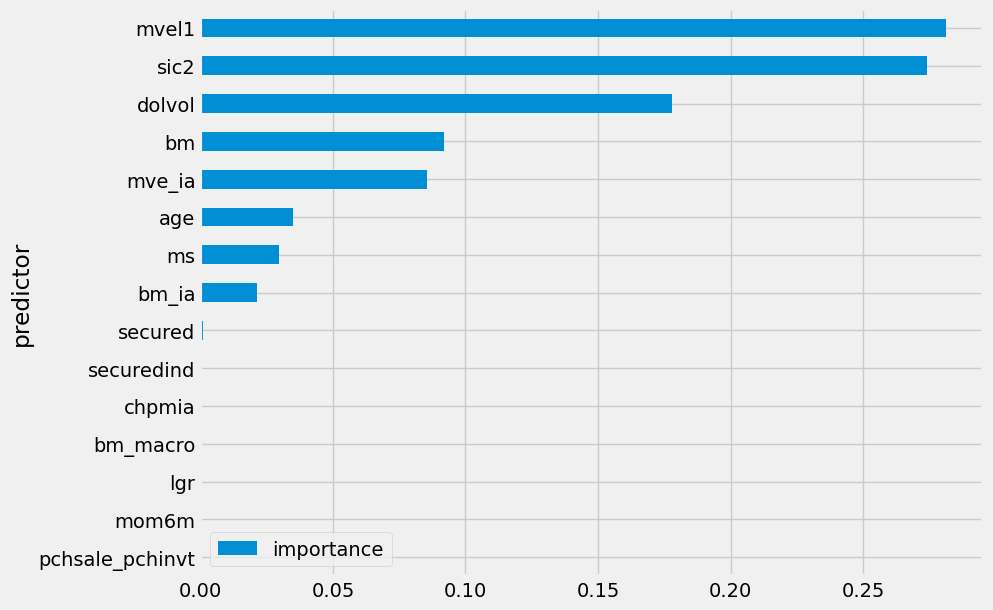

In [7]:
var_importance_agg = var_importance.sum(axis=0)
var_importance_agg[var_importance_agg < 0] = 0
var_importance_agg = var_importance_agg / var_importance_agg.sum()

var_importance_df = pd.DataFrame({'predictor': predictors, 'importance': var_importance_agg})
var_importance_df = var_importance_df.sort_values(by='importance',ascending=True).tail(15)
var_importance_df.plot.barh(x = 'predictor', y = 'importance', figsize = (9, 7))

<Axes: ylabel='predictor'>

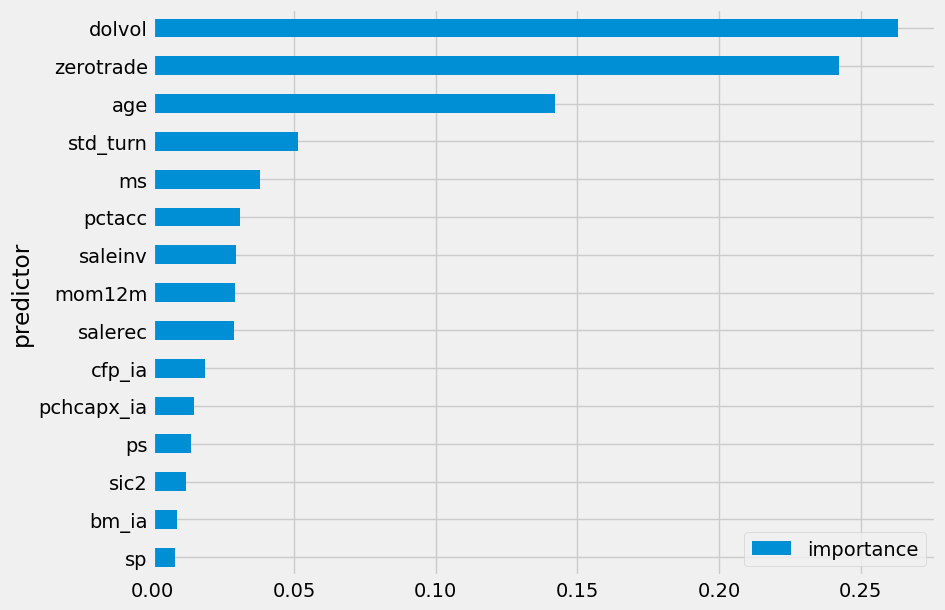

In [8]:
# SSD importance
ssd_list = []
for i in range(30):
    ssd_list.append(models[i].coef_)

ssd_importance = np.sum(np.square(ssd_list), axis=0)
ssd_importance = ssd_importance / ssd_importance.sum()

ssd_importance_df = pd.DataFrame({'predictor': predictors, 'importance': ssd_importance})
ssd_importance_df = ssd_importance_df.sort_values(by='importance',ascending=True).tail(15)
ssd_importance_df.plot.barh(x = 'predictor', y = 'importance', figsize = (9, 7))

In [9]:
# OLS-H with pre-selects size, book-to-market, and momentum covariates
features_3 = ['mvel1','bm','mom1m','mom6m','mom12m','mom36m']


# recursive evaluation
predictors = [v for v in list(data.columns) if v not in ['permno', 'yyyymm', 'RET']]
test_score = [0] * 30
models = []

for i in range(30):
    data_train = data[(data.yyyymm >= 196001 + i * 100) & (data.yyyymm < 197801 + i * 100)]
    data_validation = data[(data.yyyymm >= 197801 + i * 100) & (data.yyyymm < 199001 + i * 100)]
    data_test = data[(data.yyyymm >= 199001 + i*100) & (data.yyyymm < 199101 + i * 100)]
    print(f'batch {i}')
    print(f'train: {1960 + i}-{1978 + i}  size: {len(data_train)}')
    print(f'validate: {1978 + i}-{1990 + i}  size: {len(data_validation)}')
    print(f'test: {1990 + i}-{1991 + i}  size: {len(data_test)}')

    #Normalize
    X_train = data_train[predictors]
    X_train_selected = X_train[features_3]

    X_validation = data_validation[predictors]
    X_validation_selected = X_validation[features_3]
    
    X_all_selected = pd.concat([X_train_selected,  X_validation_selected], axis=0)
    
    X_test = data_test[predictors]
    X_test_selected = X_test[features_3]

    y_train = data_train["RET"]
    y_validation = data_validation["RET"]
    y_all = pd.concat([y_train, y_validation], axis=0)
    
    y_test = data_test["RET"]
    
   # Fit the OLS_H model using the training data
    
    #The authors choose $\xi$ as 99.9% percentile 
    
    abs_values = np.abs(X_all_selected)
    threshold = np.percentile(abs_values, 99.9)
    values_greater_than_threshold = abs_values[abs_values > threshold]
    size = len(values_greater_than_threshold)
    
    epsilon = max(size, 1)
    
    olsh = HuberRegressor(epsilon=epsilon).fit(X_all_selected,y_all)

    # Predict the target variable using the test data
    y_test_pred = olsh.predict(X_test_selected)

    # Evaluate the model's performance
    test_score[i] = r2_score(y_test,y_test_pred)
   
    models.append(olsh.fit(X_all_selected, y_all))




batch 0
train: 1960-1978  size: 52060
validate: 1978-1990  size: 71704
test: 1990-1991  size: 6704
batch 1
train: 1961-1979  size: 55788
validate: 1979-1991  size: 73566
test: 1991-1992  size: 6788
batch 2
train: 1962-1980  size: 59446
validate: 1980-1992  size: 75555
test: 1992-1993  size: 6905
batch 3
train: 1963-1981  size: 62356
validate: 1981-1993  size: 77503
test: 1993-1994  size: 7638
batch 4
train: 1964-1982  size: 65654
validate: 1982-1994  size: 79786
test: 1994-1995  size: 8182
batch 5
train: 1965-1983  size: 69030
validate: 1983-1995  size: 82472
test: 1995-1996  size: 8396
batch 6
train: 1966-1984  size: 72971
validate: 1984-1996  size: 84783
test: 1996-1997  size: 9016
batch 7
train: 1967-1985  size: 77073
validate: 1985-1997  size: 87506
test: 1997-1998  size: 9140
batch 8
train: 1968-1986  size: 81176
validate: 1986-1998  size: 90346
test: 1998-1999  size: 8744
batch 9
train: 1969-1987  size: 85625
validate: 1987-1999  size: 92452
test: 1999-2000  size: 8379
batch 10
t

Text(0, 0.5, 'score--R-square')

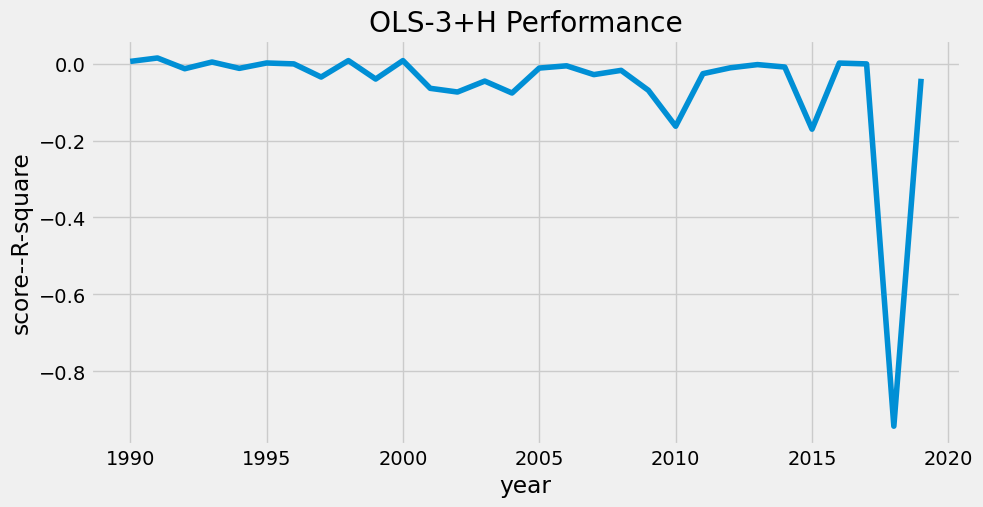

In [10]:
# Performence of OLS-3+H models
plt.figure(figsize=(10,5))
plt.title("OLS-3+H Performance")
year=np.arange(1990, 2020)
plt.plot(year, test_score)
plt.xlabel("year")
plt.ylabel("score--R-square")

In [11]:
#Variable importance
var_importance = np.zeros([30, len(features_3)])
for i in range(30):
    model = models[i]
    d = data[(data.yyyymm >= 199001 + i*100) & (data.yyyymm < 199101 + i * 100)]
    X = d[predictors]
    X = X[features_3]
    y = d['RET']
    for j in range(len(features_3)):
        X_mod = X.copy()
        X_mod.loc[:, features_3[j]] = 0
        score = r2_score(y, model.predict(X_mod))
        var_importance[i][j] = test_score[i] - score
        del X_mod

<Axes: ylabel='predictor'>

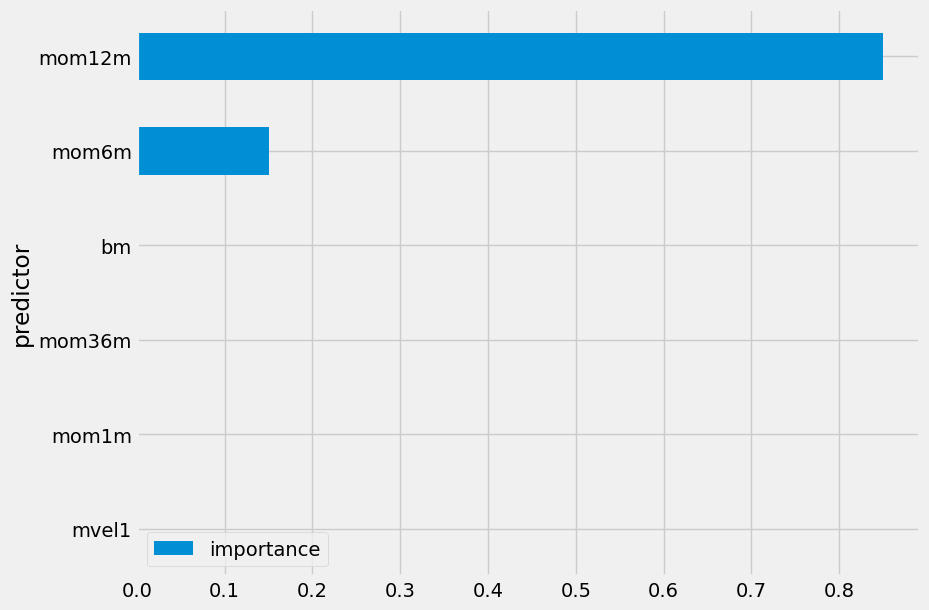

In [12]:
var_importance_agg = var_importance.sum(axis=0)
var_importance_agg[var_importance_agg < 0] = 0
var_importance_agg = var_importance_agg / var_importance_agg.sum()

var_importance_df = pd.DataFrame({'predictor': features_3, 'importance': var_importance_agg})
var_importance_df = var_importance_df.sort_values(by='importance',ascending=True).tail(15)
var_importance_df.plot.barh(x = 'predictor', y = 'importance', figsize = (9, 7))

<Axes: ylabel='predictor'>

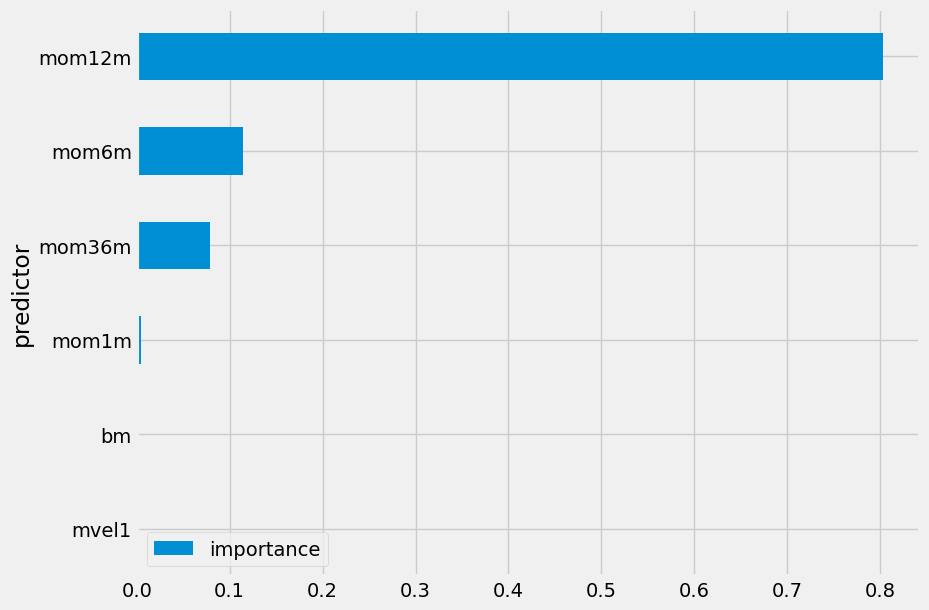

In [13]:
# SSD importance
ssd_list = []
for i in range(30):
    ssd_list.append(models[i].coef_)

ssd_importance = np.sum(np.square(ssd_list), axis=0)
ssd_importance = ssd_importance / ssd_importance.sum()

ssd_importance_df = pd.DataFrame({'predictor': features_3, 'importance': ssd_importance})
ssd_importance_df = ssd_importance_df.sort_values(by='importance',ascending=True).tail(15)
ssd_importance_df.plot.barh(x = 'predictor', y = 'importance', figsize = (9, 7))